In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
import random
from scipy.interpolate import RegularGridInterpolator
from functions_ET import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

num = 1000000
eos = "SFHo"
mns_max = mns_max = 2.058838

table = h5py.File('../horizons2/population/computed_population/bhns_%i_%s_z10_mass_spin_thv_GWFAST_ET.hdf5' %(num,eos),'r') # change this line!

DCOtype='BHNS'
poptype='A'
path = '../horizons2/importance_sampling/mass_rate/ET_COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line!

distribution = 'NOT fixed' #or 'fixed'

spin_prescription = 'Zero' #or 'Uniform'

if poptype == 'A':
    w_type='w_000'
    r0 = 81
    w_type_high = 'w_000'
    r0_high = 163
    w_type_low = 'w_000'
    r0_low = 34


### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()]
mns = table['mns'][()]
lamb_ns = table['lamb_ns'][()]
spin_bh = table['spin_bh'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
#pol = table['pol'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_out = table['m_out'][()]
final_x = table['final_x'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]

print("Loading GW population")
snr_ETT2CE = table['snr_ETT2CE'][()]
snr_ETT = table['snr_ETT'][()]
sky_loc_ETT2CE = table['sky_loc_ETT2CE'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]

snr_ETL2CE = table['snr_ETL2CE'][()]
snr_ETL = table['snr_ETL'][()]
sky_loc_ETL2CE = table['sky_loc_ETL2CE'][()]
sky_loc_ETL = table['sky_loc_ETL'][()]

print("Loading EM population (kilonova)")
kn_waves = table['kn_waves'][()]
t_kn = table['t_kn'][()]
lc_kn = table['lc_kn'][()]

print("Loading EM population (GRB afterglow)")
grb_nu = table['grb_nu'][()]
t_grb = table['t_grb'][()]
t_grb = np.logspace(-1,3,50)
th = table['th'][()]
lc_grb = table['lc_grb'][()]
grb_nu_SSC = table['grb_nu_SSC'][()]
t_grb_SSC = table['t_grb_SSC'][()]
lc_grb_SSC_NoEBL = table['lc_grb_SSC'][()]
lc_grb_SSC_NoEBL_highdens = table['lc_grb_SSC_highdens'][()]
attenuation_EBL = table['attenuation_EBL'][()]
lc_grb_SSC = lc_grb_SSC_NoEBL[:,:,:,0] * attenuation_EBL[:, :, np.newaxis]
lc_grb_SSC_highdens = lc_grb_SSC_NoEBL_highdens[:,:,:,0] * attenuation_EBL[:, :, np.newaxis]

print("Loading EM population (GRB prompt)")
bol_fluence_prompt = table['bol_fluence_prompt'][()]

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)


In [2]:
### --- Weights --- ###

np.random.seed(0)
spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50

  
if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
  
if distribution == 'NOT fixed':
    #C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    #C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
    #C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

    table_w = h5py.File('./weights_BHNS/w_bhns_%s_%s_notfixed.hdf5' %(eos,spin_prescription),'r')  # change this line!
    #read
    C_mc = table_w['C_mc'][()]
    C_mc_low = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w = table_w['w'][()]
    w_low = table_w['w_low'][()]
    w_high = table_w['w_high'][()]    
    table_w.close()

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")


EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



In [3]:
### --- Limiting Thresholds --- ###
print("COUNTERPART SEARCH (GW subthreshold)")

lim_snr = 12.

lim_kn = np.array([26.,24.5,21.])

lim_grb = np.asarray([1.e-2,2.3e-5,4.e-7])

lim_prompt_fermi = 3.09e-7
duty_fermi = 0.6
duty_CTA =  0.07

#GW
print("Computing GW limiting thresholds")

gw_det_ET = snr_ETT >= lim_snr
sky_loc_ET = sky_loc_ETT

#KILONOVA
print("Computing KN limiting thresholds")
kn_peak = np.min(lc_kn, axis=2)
kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
for j in range(len(kn_waves)):
    kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
    kn_det[:,j] = kn_peak_APP <= lim_kn[j]
kn_det_all = np.max(kn_det, axis = 1)
kn_det_g = kn_det[:,0]
kn_det_z = kn_det[:,1]
kn_det_J = kn_det[:,2]

#GRB AFTERGLOW
print("Computing GRB AFTERGLOW limiting thresholds")
grb_peak = np.max(lc_grb, axis=2)
grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
for j in range(len(grb_nu)):
    grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
    grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
grb_det_all = np.max(grb_det, axis = 1)
grb_det_radio = grb_det[:,0]
grb_det_optic = grb_det[:,1]
grb_det_x = grb_det[:,2]
grb_det_radio_15 = grb_det_15[:,0]
grb_det_optic_15 = grb_det_15[:,1]
grb_det_x_15 = grb_det_15[:,2]
grb_det_all_15 = np.max(grb_det_15, axis = 1)

#SSC
print("Computing SSC limiting thresholds")

det_SSC = np.zeros([num, len(grb_nu_SSC)])
det_SSC_highdens = np.zeros([num, len(grb_nu_SSC)])

# Determine the hemisphere for each event based on the declination of the event
emispheres = determine_emisphere(dec)

# Calculate sensitivities for both bands and both hemispheres at once
sensitivity_01 = sensitivity_CTA_vectorized(emispheres, "0.1", t_grb_SSC)
sensitivity_1 = sensitivity_CTA_vectorized(emispheres, "1", t_grb_SSC)

# Apply sensitivity thresholds to detect events
mask_01 = lc_grb_SSC[:, 1, :] > sensitivity_01  # Broadcasting comparison
mask_1 = lc_grb_SSC[:, 2, :] > sensitivity_1    # Broadcasting comparison
mask_01_highdens = lc_grb_SSC_highdens[:, 1, :] > sensitivity_01  # Broadcasting comparison
mask_1_highdens = lc_grb_SSC_highdens[:, 2, :] > sensitivity_1    # Broadcasting comparison

# Use np.any along the time dimension to find detected events
det_SSC[:, 1] = np.any(mask_01, axis=1)
det_SSC[:, 2] = np.any(mask_1, axis=1)
det_SSC_highdens[:, 1] = np.any(mask_01_highdens, axis=1)
det_SSC_highdens[:, 2] = np.any(mask_1_highdens, axis=1)

# Final detection mask
grb_det_SSC_CTA = np.max(det_SSC, axis=1)  # Mask of 0 or 1, depending on detection in at least one band
grb_det_SSC_CTA_highdens = np.max(det_SSC_highdens, axis=1)  # Mask of 0 or 1, depending on detection in at least one band


#GRB PROMPT
print("Computing GRB PROMPT limiting thresholds")
prompt_det_fermi = bol_fluence_prompt[:,0] >= lim_prompt_fermi
prompt_det_fermi_15 = bol_fluence_prompt[:,1] >= lim_prompt_fermi

COUNTERPART SEARCH (GW subthreshold)
Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing SSC limiting thresholds
Computing GRB PROMPT limiting thresholds


In [4]:
### --- Computing detection Rates --- ###

x = np.sort(z)
s = np.argsort(z)

#ALL NSNS
cum_tot = C_mc*np.cumsum(w[s])
cum_tot_high = C_mc_high*np.cumsum(w_high[s])
cum_tot_low = C_mc_low*np.cumsum(w_low[s])

#GW
cum_gw_ET = C_mc*np.cumsum(w[s]*gw_det_ET[s])
cum_gw_ET_high = C_mc_high*np.cumsum(w_high[s]*gw_det_ET[s])
cum_gw_ET_low = C_mc_low*np.cumsum(w_low[s]*gw_det_ET[s])
cum_gw_ET_norm = cum_gw_ET/cum_gw_ET[-1]

cum_gw_ET_sky = C_mc*np.cumsum(w[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_ET_high_sky = C_mc_high*np.cumsum(w_high[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_ET_low_sky = C_mc_low*np.cumsum(w_low[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))


#KN
cum_gw_kn = C_mc*np.cumsum(w[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_high = C_mc_high*np.cumsum(w_high[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_low = C_mc_low*np.cumsum(w_low[s]*kn_det_all[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_ET[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_high_sky = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_low_sky = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
cum_gw_kn_g_sky = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.)*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 

cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]

#GRB AFTERGLOW
#cum_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s])  
cum_gw_grb_only =  C_mc*np.cumsum(w[s]*grb_det_all[s])
cum_gw_grb =  C_mc*np.cumsum(w[s]*grb_det_all[s]*gw_det_ET[s])
cum_gw_grb_15 =  C_mc*np.cumsum(w[s]*grb_det_all_15[s]*gw_det_ET[s])
cum_gw_grb_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_all[s]*gw_det_ET[s])
cum_gw_grb_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_all[s]*gw_det_ET[s])

cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_ET[s])  
cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_ET[s])
cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_ET[s])  
cum_gw_grb_radio_sky =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))  
cum_gw_grb_radio_high_sky =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_grb_radio_low_sky =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))  
cum_gw_grb_radio_15 =  C_mc*np.cumsum(w[s]*grb_det_radio_15[s]*gw_det_ET[s])  
cum_gw_grb_radio_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_15[s]*gw_det_ET[s])
cum_gw_grb_radio_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_15[s]*gw_det_ET[s]) 

cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]

#SSC
cum_gw_SSC_CTA =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det_ET[s])
cum_gw_SSC_CTA_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det_ET[s])
cum_gw_SSC_CTA_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det_ET[s])
cum_gw_SSC_CTA_sky =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_SSC_CTA_high_sky =  C_mc_high*np.cumsum(w_high[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_SSC_CTA_low_sky =  C_mc_low*np.cumsum(w_low[s]*grb_det_SSC_CTA[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))

cum_gw_SSC_CTA_norm = cum_gw_SSC_CTA/cum_gw_SSC_CTA[-1]

cum_gw_SSC_CTA_highdens =  C_mc*np.cumsum(w[s]*grb_det_SSC_CTA_highdens[s]*gw_det_ET[s])
    
#GRB PROMPT 
#cum_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]) 
cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_ET[s])
cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_ET[s])
cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_ET[s])

cum_gw_fermi_sky = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_fermi_high_sky = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))
cum_gw_fermi_low_sky = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det_ET[s]*(sky_loc_ET[s]<100.))

cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det_ET[s])
cum_gw_fermi_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_15[s]*gw_det_ET[s])

cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
cum_gw_fermi_15_norm = cum_gw_fermi_15/cum_gw_fermi_15[-1]

Plotting detection rates


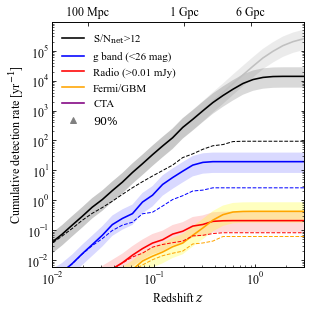

In [5]:
### --- Plotting detection Rates --- ###
print("Plotting detection rates")

#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=4.5,4.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False
#plt.rcParams['legend.handlelength'] = 0

fig1,ax = plt.subplots(1,1) 

skip = 30000

ax.loglog(x[::skip],cum_tot[::skip],c='silver',linewidth=1.6,zorder=1)
ax.fill_between(x[::skip],cum_tot_high[::skip],cum_tot_low[::skip],color='silver',alpha=0.3,edgecolor="None",zorder=1)

ax.loglog(x[::skip],cum_gw_ET[::skip],c='black',linestyle='-',linewidth=1.6,zorder=1, label = "S/N$_\mathrm{net}$>12")
ax.loglog(x[::skip],cum_gw_ET_sky[::skip],c='black',linestyle='--',linewidth=1.,zorder=1)
ax.loglog(x[::skip],cum_gw_kn_g[::skip],c='blue',linewidth=1.6,zorder=1, label="g band (<26 mag)")
ax.loglog(x[::skip],cum_gw_kn_g_sky[::skip],c='blue',ls='--',linewidth=1.,zorder=1)
ax.loglog(x[::skip],cum_gw_grb_radio[::skip],c='red',linewidth=1.6,zorder=1,ls="-",label="Radio (>0.01 mJy)")
ax.loglog(x[::skip],cum_gw_fermi[::skip]* duty_fermi,ls="-",c='orange',linewidth=1.6,zorder=1, label=r"Fermi/GBM")
ax.loglog(x[::skip],cum_gw_grb_radio_sky[::skip],c='red',linewidth=1.,zorder=1,ls="--")
ax.loglog(x[::skip],cum_gw_fermi_sky[::skip]* duty_fermi,ls="--",c='orange',linewidth=1.,zorder=1)
ax.loglog(x,cum_gw_SSC_CTA*duty_CTA,c='purple',linewidth=1.6,zorder=1,label="CTA")
ax.fill_between(x[::skip],cum_gw_ET_high[::skip],cum_gw_ET_low[::skip],color='black',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_kn_g_high[::skip],cum_gw_kn_g_low[::skip],color='blue',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_grb_radio_high[::skip],cum_gw_grb_radio_low[::skip],color='red',alpha=0.15,edgecolor="None",zorder=1)
ax.fill_between(x[::skip],cum_gw_fermi_high[::skip]* duty_fermi,cum_gw_fermi_low[::skip]* duty_fermi,color='yellow',alpha=0.25,edgecolor="None",zorder=1)

perc = 0.9
xgw = np.interp(perc,cum_gw_ET_norm[::skip],x[::skip])
ygw = np.interp(np.interp(perc,cum_gw_ET_norm[::skip],x[::skip]),x[::skip],cum_gw_ET[::skip])
xkn = np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip])
ykn = np.interp(np.interp(perc,cum_gw_kn_g_norm[::skip],x[::skip]),x[::skip],cum_gw_kn_g[::skip])
xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
yfermi = np.interp(np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip]),x[::skip],cum_gw_fermi[::skip]*duty_fermi)
xfermi_15 = np.interp(perc,cum_gw_fermi_15_norm[::skip],x[::skip])
yfermi_15 = np.interp(np.interp(perc,cum_gw_fermi_15_norm[::skip],x[::skip]),x[::skip],cum_gw_fermi_15[::skip]*duty_fermi)
xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
ygrb = np.interp(np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip]),x[::skip],cum_gw_grb_radio[::skip])

ax.errorbar(4,10000000,c='grey',marker='^',linestyle='None',elinewidth=1,capsize=2,label=r"$90\%$")

ylim = (0.006,9.e5)
xlim = (0.01,3.)

ax.legend(loc=2,frameon=False,prop={'size': 11})

ax.set_xlabel('Redshift $z$',size=12)
ax.set_ylabel(r'Cumulative detection rate [yr$^{-1}$]',size=12)
ax.set_ylim(ylim)
ax.set_xlim(xlim)
ax.set_xticks([0.01,0.1])
ax.set_xticklabels(('0.01','0.1'),size=12)
ax.minorticks_on()
ax2 = ax.twiny()
ax2.set_xlim(xlim)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.minorticks_off()
ax2.set_xticks([0.02225,0.198,0.9045])
ax2.set_xticklabels(('100 Mpc','1 Gpc','6 Gpc'),size=12)

ax.tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
ax2.tick_params(direction='in',which='both',zorder=2)
ax.yaxis.labelpad = 0.1

ax.set_yscale('log')
ax.set_xscale('log')
